In [ ]:
'''In this notebook, we will explore:
    * How it reads tokens (tokenizer)?
    * How it represents tokens as vectors (embeddings)?
    * How these embeddings will eventually be used for attention and prediction?
'''

In [ ]:
# Tokenization
'''
tokenize() splits into sub-word pieces.
encode() converts them into numeric IDs.
decode() reverses the process.
'''
from transformers import AutoTokenizer

# Load a small open model's tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

text = "Small Language Models are powerful and efficient!"
tokens = tokenizer.tokenize(text)
ids = tokenizer.encode(text)

print("Original text:", text)
print("Tokens:", tokens)
print("Token IDs:", ids)
print("Decoded back:", tokenizer.decode(ids))

In [ ]:
# A Simple Tokenizer Implementation (Toy Tokenizer)
import re

def basic_tokenizer(text):
    # Lowercase + split on spaces & punctuation
    text = text.lower()
    tokens = re.findall(r"\w+|[^\w\s]", text)
    return tokens

sample_text = "Small Language Models are powerful and efficient!"
tokens = basic_tokenizer(sample_text)
print(tokens)
    

['small', 'language', 'models', 'are', 'powerful', 'and', 'efficient', '!']


In [ ]:
'''
Real GPT-2 BPE tokenizer
1. GPT-2 uses subword tokenization (Byte Pair Encoding, BPE) to handle rare words efficiently.
2. Tokens are not always whole words; BPE splits or merges based on frequency.
3. The tokenizer’s vocabulary is fixed, built before model training. 
   Tokenizer training is often done on a subset of the full corpus (e.g., 1–10% of data), if the corpus is extremely large, to save time.
   The subset must be representative of all text the model will encounter.
   The vocabulary generated is then fixed and used throughout model training.

Analogy
Think of the vocabulary as a dictionary for the model.
You want the dictionary to cover all common words in the language you’re going to teach the model.
Making a dictionary from Shakespeare when you’re training on Wikipedia would work poorly — it won’t reflect the frequency of words in Wikipedia.
'''
from transformers import AutoTokenizer

# Load GPT-2 tokenizer (uses real BPE)
hf_tokenizer = AutoTokenizer.from_pretrained("gpt2")

text = "Small Language Models are powerful and efficient!"
tokens_hf = hf_tokenizer.tokenize(text)
ids_hf = hf_tokenizer.encode(text)

print("Original text:", text)
print("\nHugging Face BPE Tokens:", tokens_hf)
print("Token IDs:", ids_hf)
print("Decoded back:", hf_tokenizer.decode(ids_hf))
# Decoding some random token ID - Prints a word referred in the tokenizer vocabulary
print("Random Token:", hf_tokenizer.decode(18710))  

Original text: Small Language Models are powerful and efficient!

Hugging Face BPE Tokens: ['Small', 'ĠLanguage', 'ĠModels', 'Ġare', 'Ġpowerful', 'Ġand', 'Ġefficient', '!']
Token IDs: [18712, 15417, 32329, 389, 3665, 290, 6942, 0]
Decoded back: Small Language Models are powerful and efficient!
Random Token:  Hollow


In [ ]:
'''
Token Embeddings in LLMs

Definition of embedding:
* Numerical vector representing an object (word, token, or sentence) in high-dimensional space.
* Similar objects → vectors close together; dissimilar → far apart.

Purpose in Transformers / LLMs:
* Converts symbolic text into numbers so the model can process it.
* Captures semantic meaning and, in last_hidden_state, contextual meaning.

Example:
Text: "Small Language Models"
Tokens: ["Small", "ĠLanguage", "ĠModels"]
Each token → 768-dimensional vector (GPT-2 small).

Why embeddings are important:
* Provide contextualization: combined with attention, the model “understands” meaning in context.
* Allow semantic similarity: similar words (e.g., “king” & “queen”) have similar vectors.
* Serve as the starting point for downstream tasks: next-token prediction, classification, etc.

Analogy:
* Think of a map of cities
* Each city = token
* Coordinates = embedding vector
* Nearby cities = similar meaning
* Moving through the map = attention + feed-forward layers updating embeddings

last_hidden_state:
* Tensor of shape [batch_size, seq_len, hidden_size]
* Each token has a contextualized embedding vector after passing through Transformer layers.
* Before passing through layers → embeddings are basic numeric representations of tokens.
* After layers → embeddings are contextualized, rich representations used for predictions.
'''

# Extract Embeddings from GPT-2
import torch
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")

text = "Small Language Models are powerful and efficient!"
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state  # shape: [batch_size, seq_len, hidden_size]

print("Embedding shape:", embeddings.shape)
print("Number of tokens:", embeddings.shape[1])
print("Hidden size:", embeddings.shape[2])


Embedding shape: torch.Size([1, 8, 768])
Number of tokens: 8
Hidden size: 768
Embedding for first token: tensor([-0.0157, -0.0317, -0.3476, -0.1505, -0.0594, -0.2375, -0.1299, -0.0363,
        -0.1507, -0.0161])


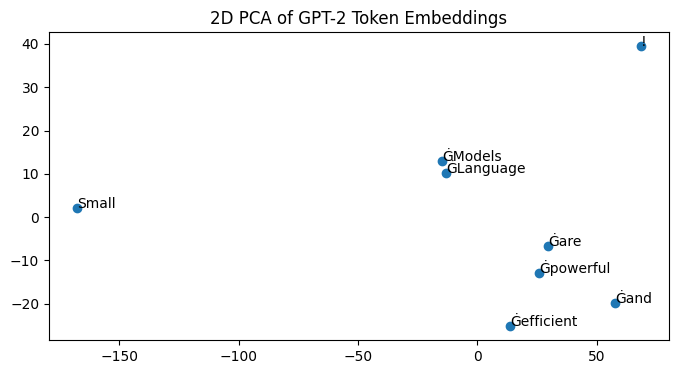

In [7]:
# Visualizing Embeddings with PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

tokens = tokenizer.tokenize(text)
emb_np = embeddings[0].numpy()  # convert from tensor to numpy

# Reduce 768-d to 2D
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_np)

plt.figure(figsize=(8,4))
plt.scatter(emb_2d[:,0], emb_2d[:,1])
for i, token in enumerate(tokens):
    plt.annotate(token, (emb_2d[i,0], emb_2d[i,1]))
plt.title("2D PCA of GPT-2 Token Embeddings")
plt.show()


In [ ]:
# Understanding & Visualizing Attention (GPT-2)